# Wonderful Wines of the World

## Timeline

Thursday: Finish most of the code; 

Friday: Combine best clusters; Agree on final clustering solution

Sat/Sun: Finish Paper Draft / Presentation Draft


## Paper

Business Understanding
- 1 paragraph about problem statement

Data Understanding
- No missing values
- Remove last row
- No duplicates
- Initial Histograms + Box plots

Data Prep
- Outliers
- RobustScaler Transform (Default position)

--- 1 page ---

Modelling (Value + Wine)

Clusters: 4-6

M: V / L: W
- Kmeans
- Hierarchical

F: V / B: W
- SOM
- Density Based (GMM, MS, DBSCAN)


Combined:
- Hierarchical

RFM??

Evaluation
- Summary of R2 scores
- Other Evaluation metric
- Cluster characterization - Mention RFM in relation to final clusters ?
- UMAP / TSNE viz to evaluate if points in the same clusters are near each other

--- 3 pages ---

Deployment
- Marketing strategy summary
- Add parallel plots 

--- end ---

## Presentation

- Intro: Describe problem and summary
- Wine Seg vs Value Seg
- Combi
- Which model/s and why
- Mostly evaluation 
- Marketing strategy
- Implications


## Initial Setup

In [1]:
## import libraries

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import os
from math import ceil



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


In [3]:
from sklearn.base import clone

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth


from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

#import graphviz

import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [4]:
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# importing sompy enables more logging
logging.disable(logging.INFO)

In [5]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)
#print('Sompy version', sompy.__version__)


Pandas version  1.4.1
Numpy version  1.22.2
Scipy version  1.8.0
Seaborn version  0.11.2


## Define some constant variables

In [6]:
#COLORS=['#d1d646', '#a7ca58', '#78bd6c', '#44af82', '#009c9f', '#4d8b8f', '#516c85', '#544b7b', '#59236f']
COLORS = ['#cc2a49', '#e06e60', '#f0a573', '#ffd884', '#ae9e95', '#5d7495', '#004494']
COLORS = ['#7a2b5d', '#975c86', '#b38dad', '#d0bed6', '#edf0ff', '#eae1cd', '#e8d19a', '#e6c064', '#e3ae29']

CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy() #['#9faf1f', '#aac55d', '#b5da99', '#d7ebcb', '#fafafa', '#dbc5d5', '#cb9ebf', '#bb77a8', '#ae4c8c']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)

sns.set_palette(DEFAULT_PALETTE)
DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False


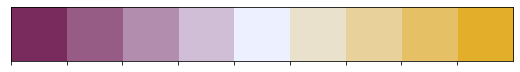

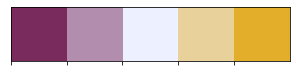

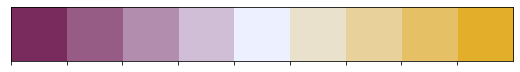

In [7]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
plt.show()

In [8]:
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 70

In [9]:
show_plots = True
save_plots = False
img_counter = 0
random_state = 0

## Define some functions

In [10]:
def save_fig(title, fig, dest='img/'):
    if save_plots == True:
        fn = dest + '_' + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [11]:
## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Numeric Variables' Histograms"):
    fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), \
                             constrained_layout=True)
        
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], color=COLORS[0])
        ax.set_title(feat, y=1)
    
    if (len(axes.flatten())) > len(features):
        for f in range(len(axes.flatten())-len(features)):
            axes.flatten()[(f+1)*-1].axis('off')
    plt.suptitle(title)
    save_fig(title, fig)

    plt.show()

In [12]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        fig = plt.figure(figsize=(5*rows,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [13]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




## Load Dataset

In [14]:
df = pd.read_excel('../data/WonderfulWinesoftheWorld.xlsx')
df_original = df.copy(deep=True)

## Remove last row
df.drop(df.tail(1).index,inplace=True)

df['Custid'] = df['Custid'].astype(int) # <-- this one
df.set_index('Custid', inplace=True)

df.head(3)

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
Custid,,,,,,,,,,,,,,,,,
5325,653.0,55.0,20.0,78473.0,20.0,18.0,826.0,445.0,7.0,67.0,4.0,26.0,2.0,1.0,1.0,36.0,5.0
3956,1041.0,75.0,18.0,105087.0,36.0,33.0,1852.0,539.0,2.0,49.0,0.0,46.0,1.0,3.0,0.0,20.0,4.0
3681,666.0,18.0,12.0,27984.0,4.0,56.0,39.0,-7.0,88.0,4.0,29.0,14.0,32.0,21.0,48.0,60.0,8.0


In [15]:
df.shape

(10000, 17)

In [16]:
df.isna().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

## Data Understanding

### Check datatypes

In [17]:
df.dtypes

Dayswus        float64
Age            float64
Edu            float64
Income         float64
Freq           float64
Recency        float64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
dtype: object

All variables are numeric.

### Check for duplicates

In [18]:
print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []


### Identify features for segmentation

In [19]:
## Wine preference features
wine_features = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']

## Value segmentation features
value_features = ['Dayswus', 'Freq', 'Recency', 'Monetary', 'LTV', 'Perdeal']

## Separate Demographic features for cluster descriptions later
demog_features = ['Age', 'Edu', 'Income']

## Separate other features
other_features = ['WebPurchase', 'WebVisit']


### Distributions of values for variables

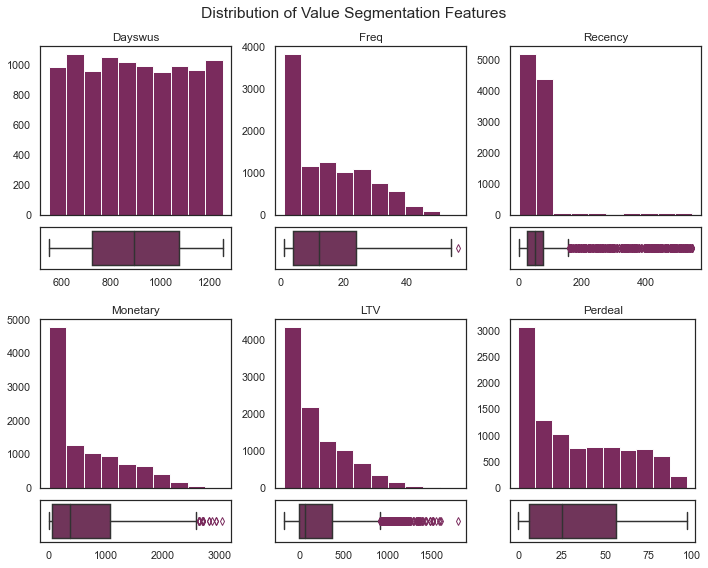

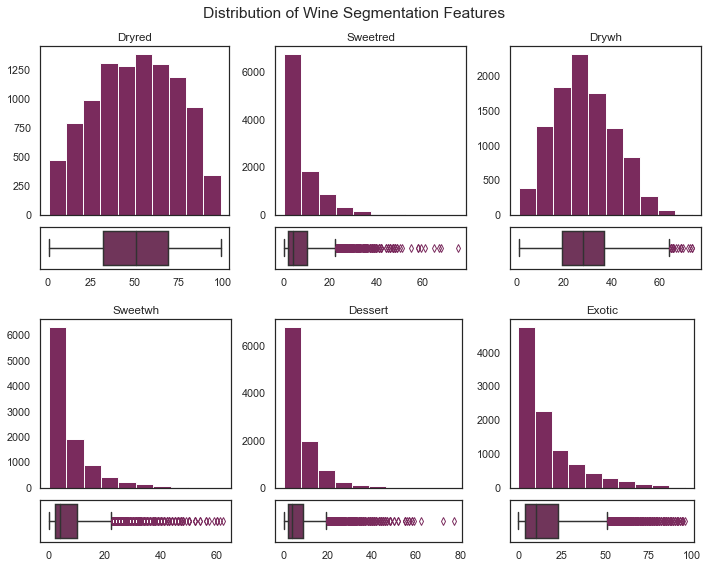

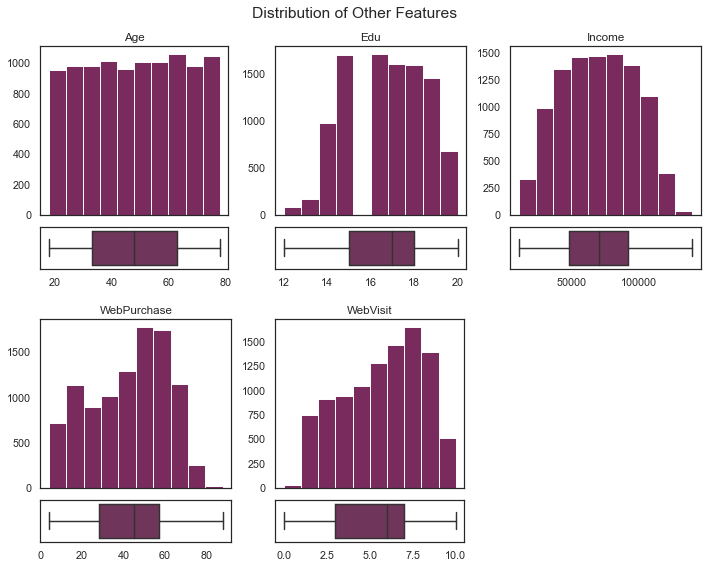

In [20]:
plot_histograms_boxplots(df, value_features, rows=2, title='Distribution of Value Segmentation Features')
plot_histograms_boxplots(df, wine_features, rows=2, title='Distribution of Wine Segmentation Features')
plot_histograms_boxplots(df, (demog_features+other_features), rows=2, title='Distribution of Other Features')

## Data Preparation

### Check for correlation

In [21]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    l = len(df.columns.tolist())
    fig = plt.figure(figsize=(2*l, 1.5*l))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=2);
    save_fig(title, fig)
    plt.show()

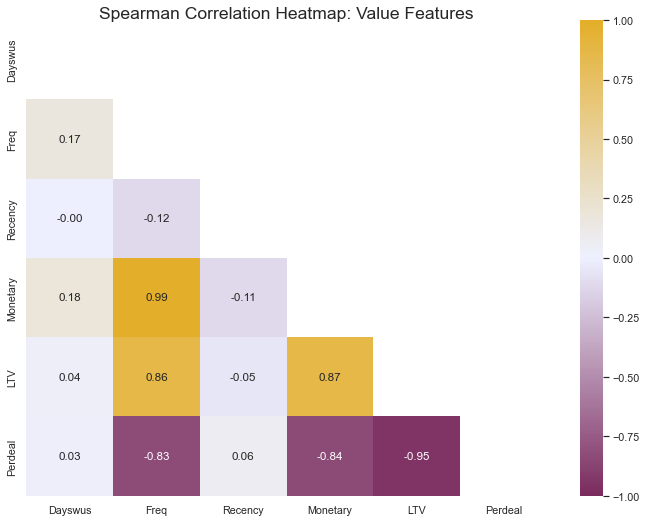

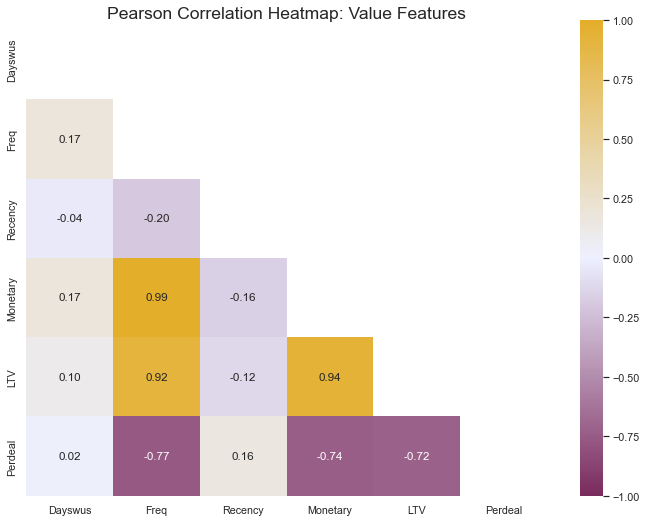

In [22]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap: Value Features")
make_corr_heatmap(df[value_features], 'pearson', title="Pearson Correlation Heatmap: Value Features")


In [23]:
## Remove Perdeal because highly correlated with multiple feats
value_features.remove('Perdeal')

## Remove Monetary because highly correlated with Freq, LTV
value_features.remove('Monetary')


## Remove Frequency and LTV because highly correlated with Monetary
value_features2 = ['Dayswus', 'Recency', 'Monetary']

value_features

['Dayswus', 'Freq', 'Recency', 'LTV']

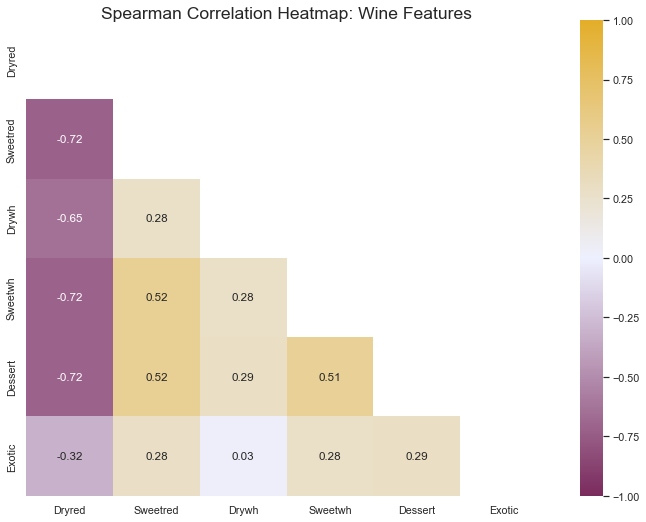

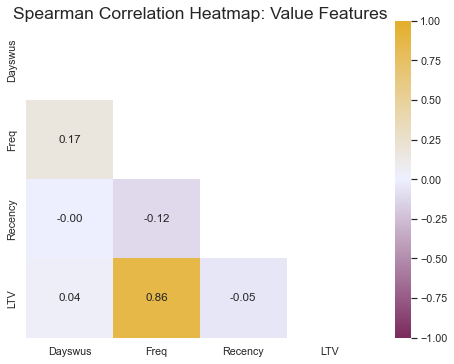

In [24]:
make_corr_heatmap(df[wine_features], 'spearman', title="Spearman Correlation Heatmap: Wine Features")
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap: Value Features")


### Check for outliers

In [25]:
for v in df.columns.tolist():
    getIQR(df, v)

363 or 3.63% of rows are above the UL [Recency].
117 or 1.17% of rows are above the UL [LTV].
358 or 3.58% of rows are above the UL [Sweetred].
2 or 0.02% of rows are above the UL [Drywh].
365 or 3.65% of rows are above the UL [Sweetwh].
474 or 4.74% of rows are above the UL [Dessert].
331 or 3.31% of rows are above the UL [Exotic].


Too many outliers to remove just based on IQR

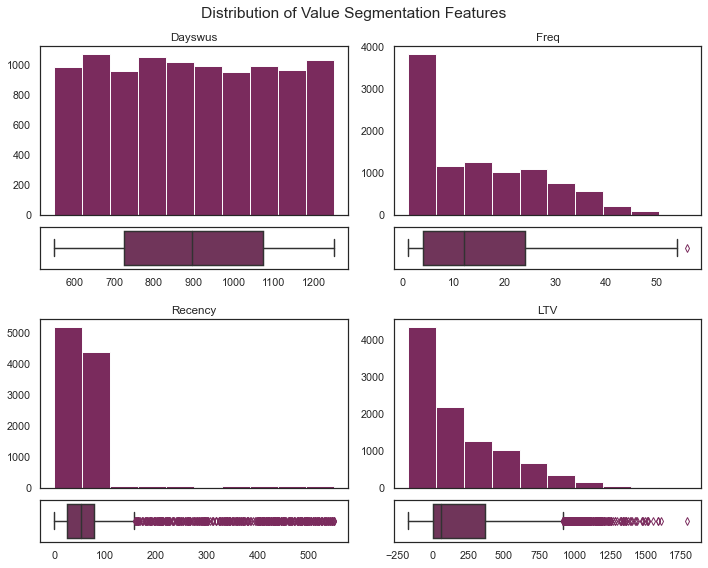

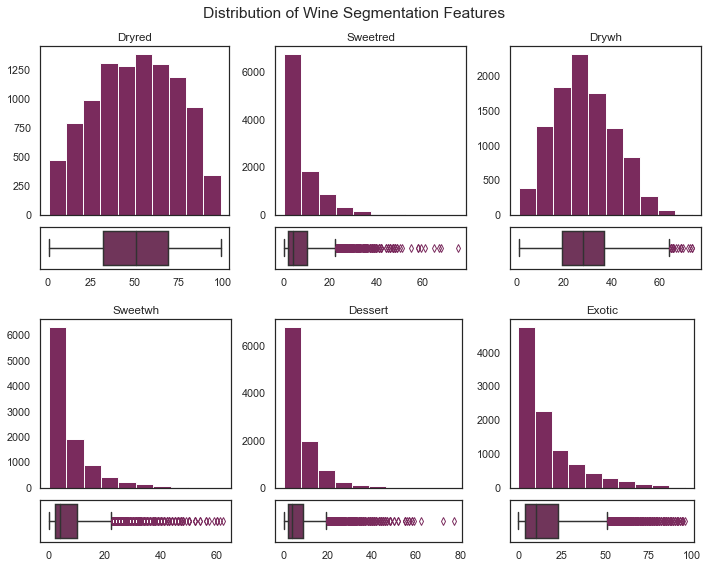

In [26]:
plot_histograms_boxplots(df, value_features, rows=2, title='Distribution of Value Segmentation Features')
plot_histograms_boxplots(df, wine_features, rows=2, title='Distribution of Wine Segmentation Features')

In [27]:
df['Outlier'] = 0

In [28]:
df.loc[df['Dessert']>70,['Outlier']] = 1
df.loc[df['Sweetred']>70,['Outlier']] = 1

In [29]:
df.loc[df['Freq']>55,['Outlier']] = 1
df.loc[df['LTV']>1750,['Outlier']] = 1

In [30]:
df_outliers = df.copy()

In [31]:
df = df[df['Outlier']==0]

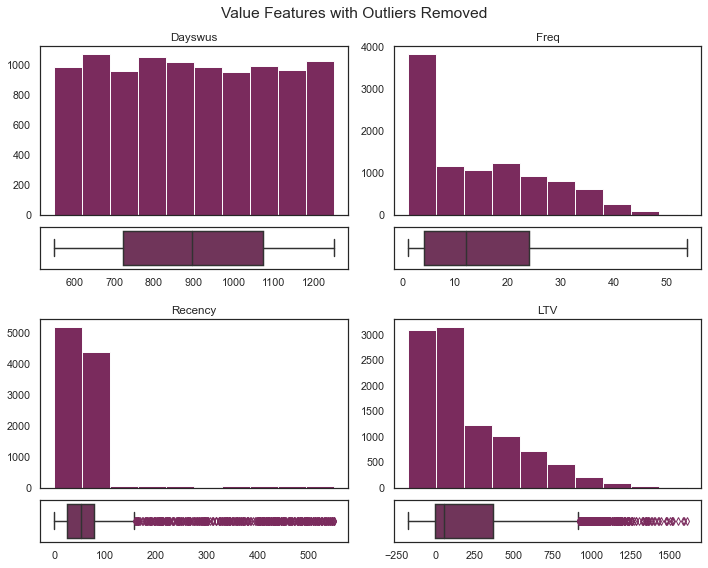

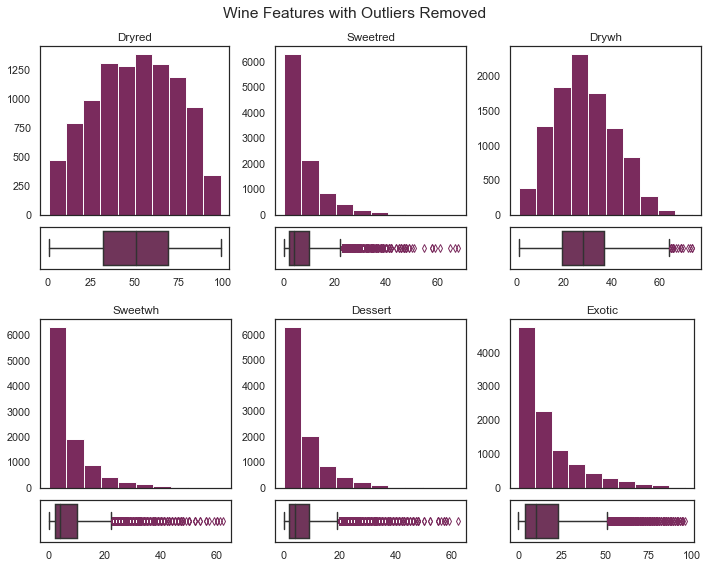

In [32]:
plot_histograms_boxplots(df, value_features, rows=2, title='Value Features with Outliers Removed')
plot_histograms_boxplots(df, wine_features, rows=2, title='Wine Features with Outliers Removed')



## Transform Variables

### MinMax Scaler

We only scale the Value Segmentation Features because the Wine Segmentation Features are all in the same scale (percentage) already.

In [33]:
mmscaler = MinMaxScaler()

value_feats_mm = value_features.copy()

for fi in range(len(value_feats_mm)):
    t = value_feats_mm[fi] + '_mm'
    value_feats_mm[fi] = t
    df[t] = df[value_features[fi]]

df[value_feats_mm] = mmscaler.fit_transform(df[value_feats_mm])


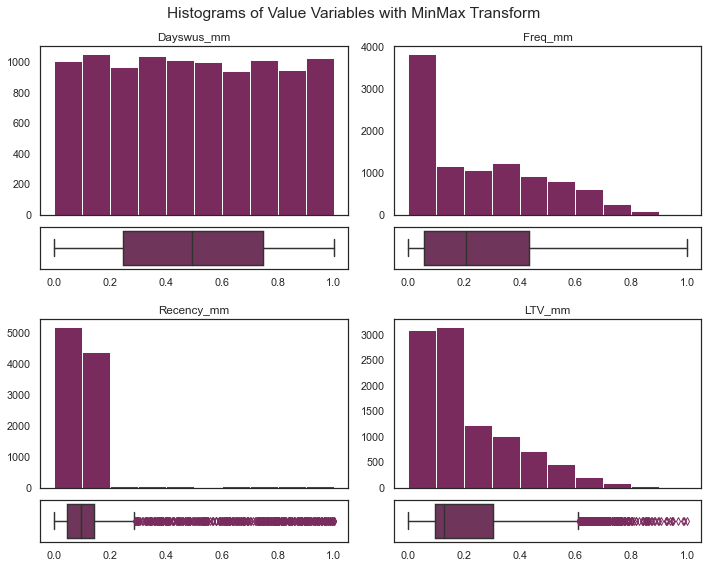

In [34]:
plot_histograms_boxplots(df, value_feats_mm, rows=2, title='Histograms of Value Variables with MinMax Transform')


### Transform wine features to decimal (from percentage)

In [35]:
wine_feats_dec = wine_features.copy()

for fi in range(len(wine_feats_dec)):
    t = wine_feats_dec[fi] + '_dec'
    wine_feats_dec[fi] = t
    df[t] = df[wine_features[fi]]/100


## Use DBSCAN to identify 'noise' rows

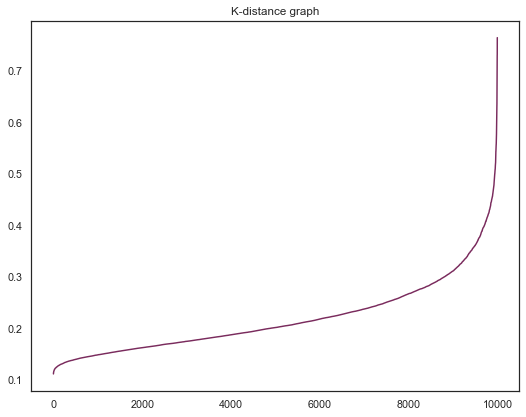

In [36]:
## DBSCAN

# K-distance graph to find out the right eps value
vars_ = wine_feats_dec + value_feats_mm
neigh = NearestNeighbors(n_neighbors=50)
neigh.fit(df[vars_])
distances, _ = neigh.kneighbors(df[vars_])
distances = np.sort(distances[:, -1])

fig, axis = plt.subplots(figsize=(9,7))
plt.plot(distances, color=COLORS[0])
plt.title('K-distance graph')
plt.show()


In [37]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=.35, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[vars_])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [38]:
# Concatenating the labels to df
df_dbscan = pd.concat([df[vars_], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_dbscan.groupby(['dbscan_labels']).count()

,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm
dbscan_labels,,,,,,,,,,
-1,30,30,30,30,30,30,30,30,30,30
0,9966,9966,9966,9966,9966,9966,9966,9966,9966,9966


In [39]:
df_nonoise = df_dbscan.loc[df_dbscan['dbscan_labels'] != -1]

In [40]:
print('Percentage of rows considered noise:')
100*len(df_dbscan.loc[df_dbscan['dbscan_labels'] == -1])/len(df)

Percentage of rows considered noise:


0.30012004801920766

## Summary of Variables

In [41]:
## Original value features
print(value_features)
df[value_features].head(3)

['Dayswus', 'Freq', 'Recency', 'LTV']


,Dayswus,Freq,Recency,LTV
Custid,,,,
5325,653.0,20.0,18.0,445.0
3956,1041.0,36.0,33.0,539.0
3681,666.0,4.0,56.0,-7.0


In [42]:
## Original wine features
print(wine_features)
df[wine_features].head(3)

['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']


,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
Custid,,,,,,
5325,67.0,4.0,26.0,2.0,1.0,1.0
3956,49.0,0.0,46.0,1.0,3.0,0.0
3681,4.0,29.0,14.0,32.0,21.0,48.0


In [43]:
## MinMax transformed value features
print(value_feats_mm)
df[value_feats_mm].head(3)

['Dayswus_mm', 'Freq_mm', 'Recency_mm', 'LTV_mm']


,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm
Custid,,,,
5325,0.147143,0.358491,0.032787,0.348824
3956,0.701429,0.660377,0.060109,0.401456
3681,0.165714,0.056604,0.102004,0.095745


In [44]:
## Decimal wine features
print(wine_feats_dec)
df[wine_feats_dec].head(3)

['Dryred_dec', 'Sweetred_dec', 'Drywh_dec', 'Sweetwh_dec', 'Dessert_dec', 'Exotic_dec']


,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec
Custid,,,,,,
5325,0.67,0.04,0.26,0.02,0.01,0.01
3956,0.49,0.00,0.46,0.01,0.03,0.00
3681,0.04,0.29,0.14,0.32,0.21,0.48


## Clustering

## SOM + KMEANS/HCLUST

In [45]:
df_wine = df[wine_feats_dec].copy()

In [53]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

In [54]:
def clust_r2(df, kmeans, hclust, title='Continuous'):

    # Obtaining the R² scores for each cluster solution on continuous variables
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(df, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            df, hclust.set_params(linkage=linkage)
        )

    pd.DataFrame(r2_scores)

    # Visualizing the R² scores for each cluster solution on demographic variables
    pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

    plt.title(f"{title} Variables:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)
    plt.show()

In [55]:
kmeans = KMeans(n_init=15, random_state=42)

hclust = AgglomerativeClustering(compute_distances=True)

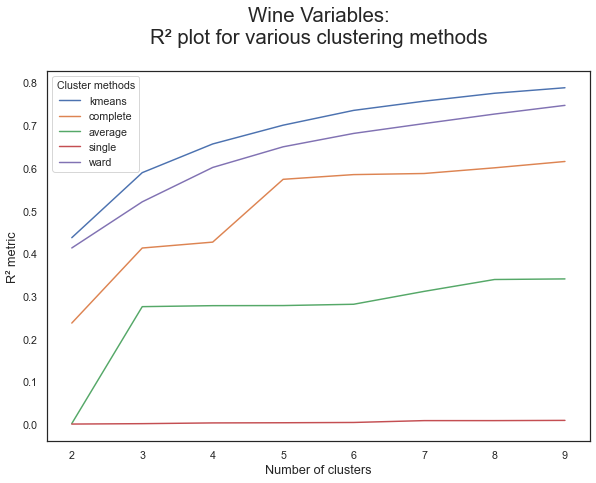

In [56]:
clust_r2(df_wine, kmeans, hclust, 'Wine')

In [57]:
# Setting seed parameter
np.random.seed(42)

# Training the SOM
sm = sompy.SOMFactory().build(
    df_wine.values, 
    mapsize=[50, 50],
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=wine_feats_dec
)
sm.train(n_job=-1, verbose='info', train_rough_len=100, train_finetune_len=100)

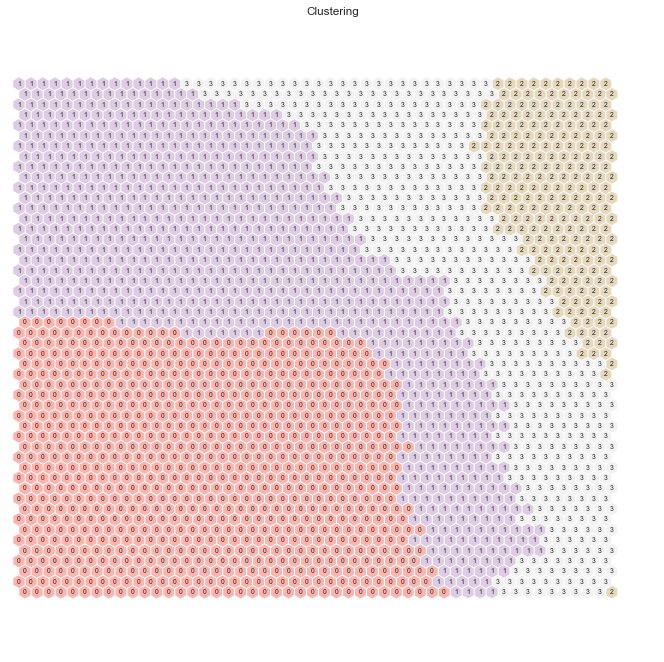

In [58]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [59]:
# Check the nodes and and respective clusters
wine_som_nodes = sm.codebook.matrix

df_wine_som_nodes = pd.DataFrame(wine_som_nodes, columns=wine_feats_dec)
df_wine_som_nodes['wine_nodes'] = nodeclus_labels
df_wine_som_nodes

,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec,wine_nodes
0,-1.331036,0.994397,1.032707,0.581023,0.731700,3.171333,2
1,-1.229045,1.230373,0.968145,0.242817,0.645742,2.843605,3
2,-0.968703,1.134350,0.720724,0.183670,0.418735,2.709762,3
3,-0.702601,0.820353,0.403849,0.263079,0.367105,2.626178,3
4,-0.537435,0.467020,0.221231,0.513712,0.258795,2.635300,3
...,...,...,...,...,...,...,...
2495,-0.833574,-0.064986,1.884723,-0.231788,-0.236309,0.374971,1
2496,-0.946106,-0.190836,2.113529,-0.173857,-0.195788,0.368755,1
2497,-1.095786,-0.175691,2.376515,-0.157243,-0.196739,0.219167,1
2498,-1.125802,-0.141912,2.454379,-0.152896,-0.267144,-0.142131,1


In [61]:
# Obtaining SOM's BMUs labels
bmus_map = sm.find_bmu(df_wine)[0]  # get bmus for each observation in df

df_bmus = pd.DataFrame(
    np.concatenate((df, np.expand_dims(bmus_map,1)), axis=1),
    index=df.index, columns=np.append(df.columns,"BMU")
)
df_bmus

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,...,Freq_mm,Recency_mm,LTV_mm,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec,BMU
Custid,,,,,,,,,,,,,,,,,,,,,
5325,653.0,55.0,20.0,78473.0,20.0,18.0,826.0,445.0,7.0,67.0,...,0.358491,0.032787,0.348824,0.67,0.04,0.26,0.02,0.01,0.01,665.0
3956,1041.0,75.0,18.0,105087.0,36.0,33.0,1852.0,539.0,2.0,49.0,...,0.660377,0.060109,0.401456,0.49,0.00,0.46,0.01,0.03,0.00,614.0
3681,666.0,18.0,12.0,27984.0,4.0,56.0,39.0,-7.0,88.0,4.0,...,0.056604,0.102004,0.095745,0.04,0.29,0.14,0.32,0.21,0.48,608.0
2829,1049.0,42.0,16.0,61748.0,2.0,46.0,37.0,-6.0,70.0,86.0,...,0.018868,0.083789,0.096305,0.86,0.01,0.11,0.01,0.01,0.55,616.0
8788,837.0,47.0,16.0,65789.0,2.0,3.0,36.0,4.0,35.0,85.0,...,0.018868,0.005464,0.101904,0.85,0.00,0.12,0.02,0.01,0.28,666.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,1132.0,57.0,20.0,81033.0,19.0,59.0,776.0,187.0,22.0,78.0,...,0.339623,0.107468,0.204367,0.78,0.00,0.20,0.01,0.01,0.11,615.0
4070,596.0,66.0,15.0,84714.0,18.0,45.0,720.0,391.0,5.0,30.0,...,0.320755,0.081967,0.318589,0.30,0.12,0.36,0.10,0.12,0.13,664.0
7909,619.0,18.0,12.0,40466.0,3.0,65.0,47.0,5.0,23.0,6.0,...,0.037736,0.118397,0.102464,0.06,0.24,0.10,0.38,0.22,0.41,716.0


In [64]:
# Get cluster labels for each observation
df_ = df_bmus.merge(df_wine_som_nodes['wine_nodes'], 'left', left_on="BMU", right_index=True)

# Characterizing the final clusters
df_.drop(columns='BMU').groupby('wine_nodes').mean()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,...,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec
wine_nodes,,,,,,,,,,,,,,,,,,,,,
0,997.857143,26.142857,15.571429,37785.285714,4.000000,108.142857,84.857143,-9.000000,58.571429,41.714286,...,0.639796,0.056604,0.196982,0.094625,0.417143,0.112857,0.111429,0.311429,0.050000,0.785714
1,897.990799,48.528522,16.804232,70824.152525,14.874668,62.152934,635.029237,213.567880,31.838888,51.277346,...,0.497130,0.261786,0.113211,0.219243,0.512773,0.066351,0.287301,0.067796,0.065534,0.153815
3,897.038647,20.516908,13.729469,27912.062802,3.294686,72.531401,47.951691,-0.642512,57.801932,8.913043,...,0.495769,0.043296,0.132115,0.099304,0.089130,0.264638,0.195894,0.200193,0.249903,0.690725


In [81]:
df_.drop('BMU', axis=1, inplace=True)

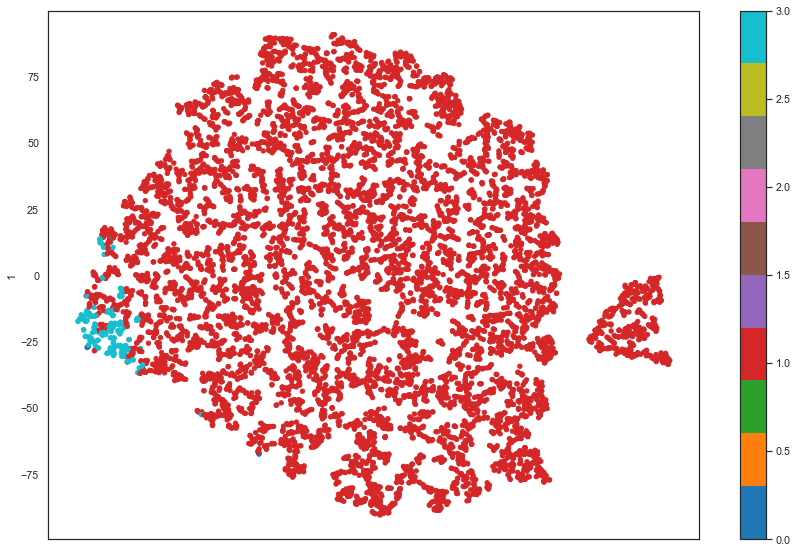

In [84]:
# This step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=20).fit_transform(df_[wine_feats_dec])

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_['wine_nodes'], colormap='tab10', figsize=(15,10))
plt.show()

In [87]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_[wine_feats_dec + ['wine_nodes']])  # get total sum of squares
ssw_labels = df_[wine_feats_dec + ['wine_nodes']].groupby(by='wine_nodes').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.4660920531513516

## DBSCAN

In [93]:
def dbscan_distplot(df):
    # K-distance graph to find out the right eps value
    minpts = len(df.columns.tolist())*2
    neigh = NearestNeighbors(n_neighbors=minpts-1)
    neigh.fit(df)
    distances, _ = neigh.kneighbors(df)
    distances = np.sort(distances[:, -1])
    plt.plot(distances)
    plt.show()
    
def dbscan_clust(df, eps=1.0, metric='euclidean', metric_params=None, min_samples=len(df.columns.tolist())*2):
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(
        eps=2.0, 
        min_samples=min_samples, 
        n_jobs=-1, 
        metric=metric, 
        metric_params=metric_params
    )
    
    dbscan_labels = dbscan.fit_predict(df)
    dbscan_n_clusters = len(np.unique(dbscan_labels))
    print("Number of estimated clusters : %d" % dbscan_n_clusters)
    
    # Concatenating the DBSCAN labels to df
    df_dbscan = pd.concat([df, pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
    
    # Computing the R^2 of the cluster solution
    #print("Cluster solution with R^2 of %0.4f" % r2(df_dbscan, dbscan_labels))
    
    return df_dbscan

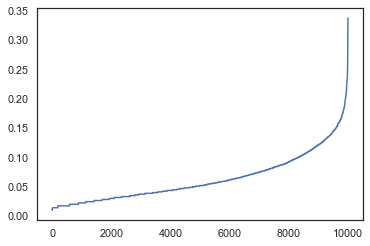

In [89]:
dbscan_distplot(df_wine)

In [94]:
df_dbscan = dbscan_clust(df_wine, eps=0.1)

Number of estimated clusters : 1


In [100]:
df_dbscan

,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec,dbscan_labels
Custid,,,,,,,
5325,0.67,0.04,0.26,0.02,0.01,0.01,0
3956,0.49,0.00,0.46,0.01,0.03,0.00,0
3681,0.04,0.29,0.14,0.32,0.21,0.48,0
2829,0.86,0.01,0.11,0.01,0.01,0.55,0
8788,0.85,0.00,0.12,0.02,0.01,0.28,0
...,...,...,...,...,...,...,...
1383,0.78,0.00,0.20,0.01,0.01,0.11,0
4070,0.30,0.12,0.36,0.10,0.12,0.13,0
7909,0.06,0.24,0.10,0.38,0.22,0.41,0
